In [14]:
import jax
from jaxmarl import make
from jaxmarl.viz.visualizer import SMAXVisualizer

from matplotlib import pyplot as plt

In [15]:
key = jax.random.PRNGKey(0)
key, key_reset = jax.random.split(key)
env = make("SMAX", use_self_play_reward=False, walls_cause_death=True, see_enemy_actions=False)

In [16]:
obs, state = env.reset(key_reset)
state_seq = []
for i in range(3):
    key, key_step, key_act = jax.random.split(key, 3)
    key_acts = jax.random.split(key_act, len(env.agents))
    actions = {agent: env.action_space(agent).sample(key_acts[i]) for i, agent in enumerate(env.agents)}
    obs, state, reward, done, infos = env.step(key_step, state, actions)
    state_seq.append((key_step, state, actions))

{'ally_0': Array(0., dtype=float32), 'ally_1': Array(0., dtype=float32), 'ally_2': Array(0., dtype=float32), 'ally_3': Array(0., dtype=float32), 'ally_4': Array(0., dtype=float32), 'enemy_0': Array(0., dtype=float32), 'enemy_1': Array(0., dtype=float32), 'enemy_2': Array(0., dtype=float32), 'enemy_3': Array(0., dtype=float32), 'enemy_4': Array(0., dtype=float32)}
{'ally_0': Array(0., dtype=float32), 'ally_1': Array(0., dtype=float32), 'ally_2': Array(0., dtype=float32), 'ally_3': Array(0., dtype=float32), 'ally_4': Array(0., dtype=float32), 'enemy_0': Array(0., dtype=float32), 'enemy_1': Array(0., dtype=float32), 'enemy_2': Array(0., dtype=float32), 'enemy_3': Array(0., dtype=float32), 'enemy_4': Array(0., dtype=float32)}
{'ally_0': Array(0., dtype=float32), 'ally_1': Array(0., dtype=float32), 'ally_2': Array(0., dtype=float32), 'ally_3': Array(0., dtype=float32), 'ally_4': Array(0., dtype=float32), 'enemy_0': Array(0., dtype=float32), 'enemy_1': Array(0., dtype=float32), 'enemy_2': Ar

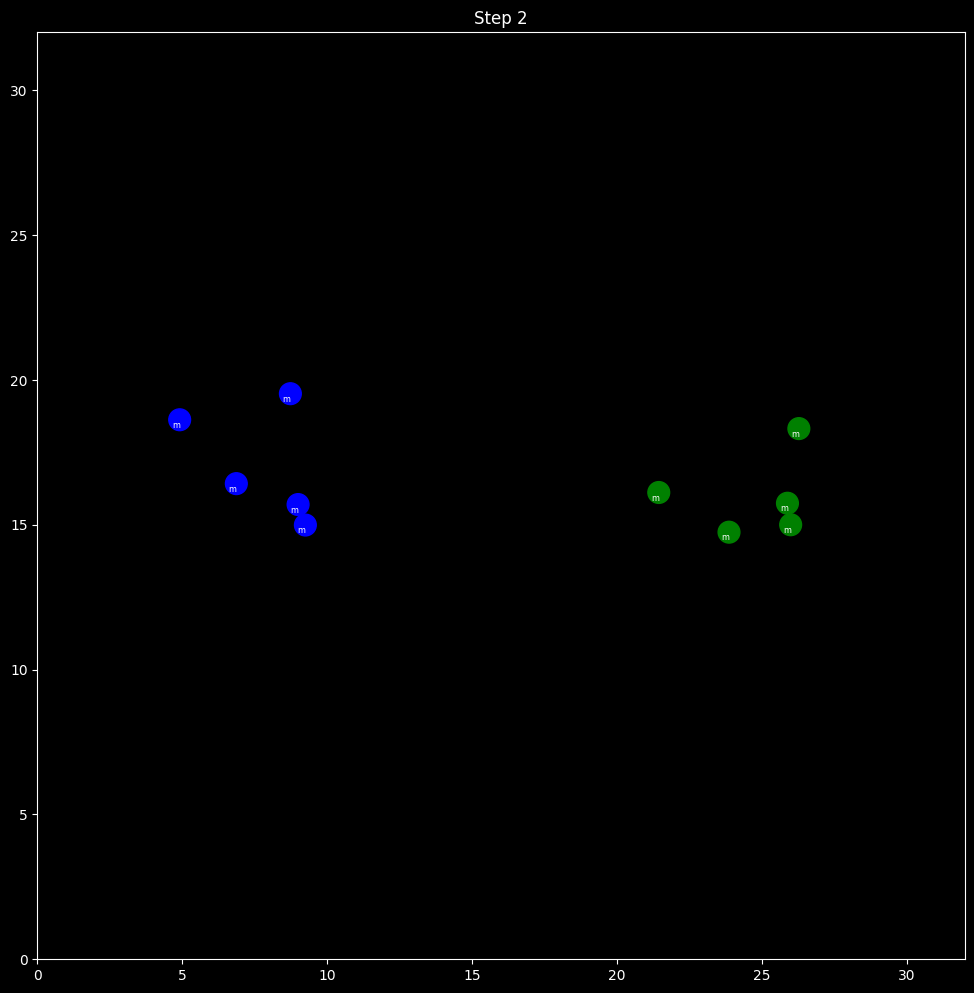

In [26]:
def vizualize(state_seq):
    viz = SMAXVisualizer(env, state_seq)
    viz.fig.set_size_inches(10, 10)
    # hide the axes
    viz.fig.tight_layout()
    viz.animate(view=True, save_fname="output.gif")
    plt.close()
    

vizualize(state_seq)